<ipython-input-17-d1a9cbbb9cc8>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values
<ipython-input-17-d1a9cbbb9cc8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-17-d1a9cbbb9cc8>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.month
<ipython-input-17-d1a9cbbb9cc8>:26: S

Random Forest Model Performance:
MAE: 19.773531604812742
MSE: 2220.4133913065584
R2 Score: 0.8909278360111538
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


738/738 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: nan - val_loss: nan
Epoch 2/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: nan - val_loss: nan
Epoch 3/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: nan - val_loss: nan
Epoch 4/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: nan - val_loss: nan
Epoch 5/5
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: nan - val_loss: nan
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
LSTM Model Performance:
MAE: 165.45839688188443
MSE: 47733.76851381122
R2 Score: -1.3448000482830924


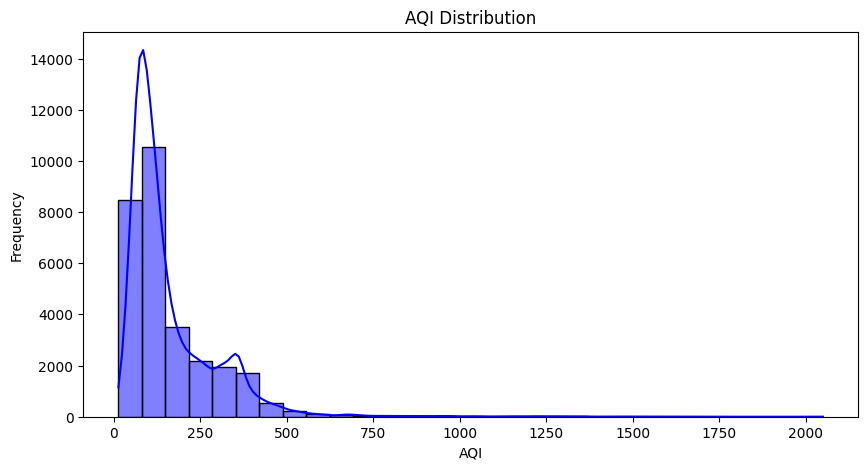

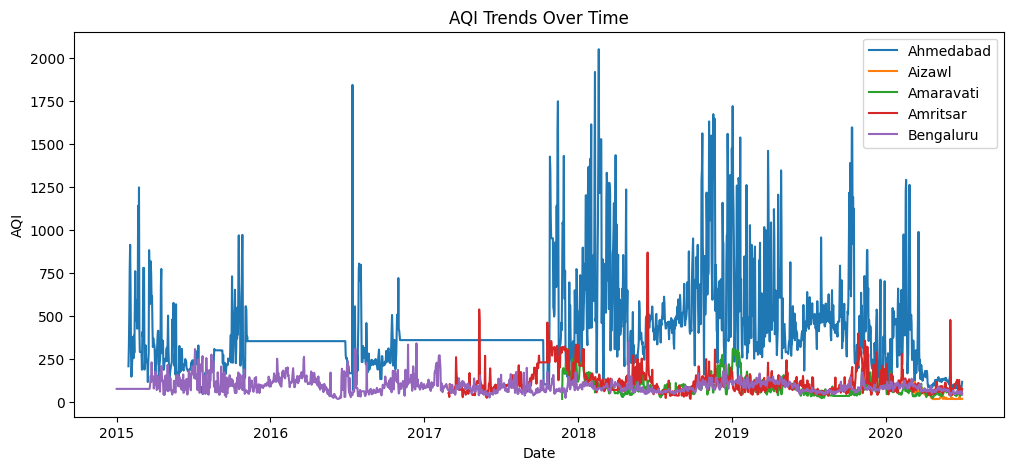

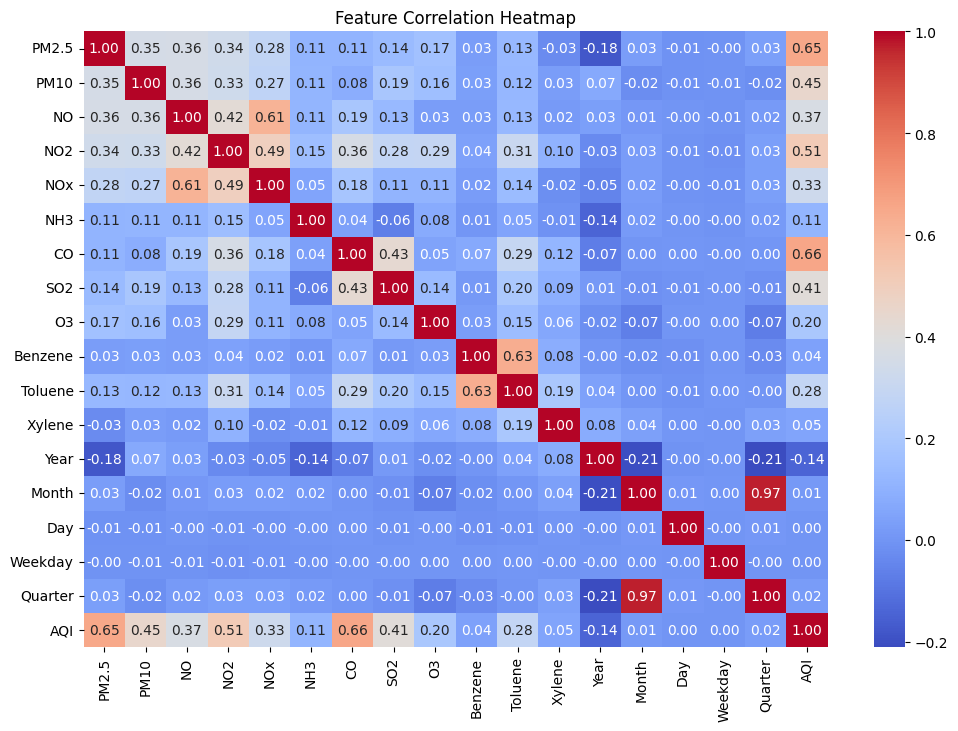

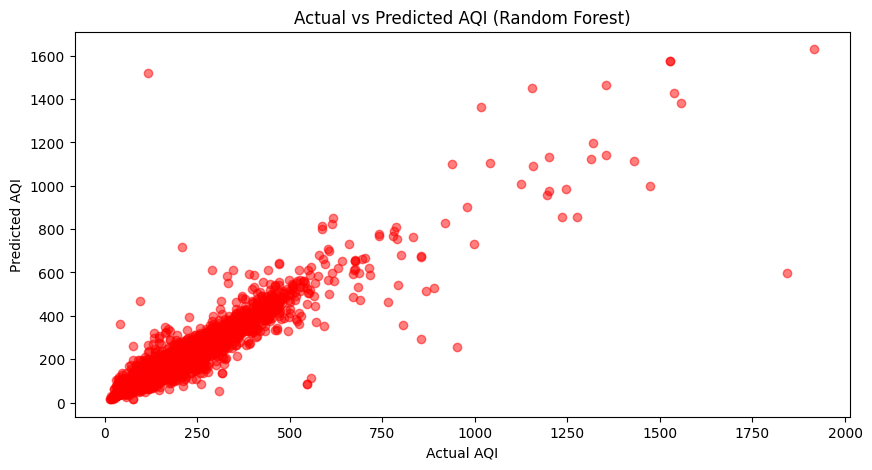

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/city_day.csv")

# Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['City', 'Date'], inplace=True)
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Drop rows where AQI is missing
df = df.dropna(subset=['AQI'])

# Feature Engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter

# Selecting Features and Target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'Year', 'Month', 'Day', 'Weekday', 'Quarter']
target = 'AQI'

X = df[features]
y = df[target]

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Random Forest Metrics
print("Random Forest Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

# LSTM Model
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)),
    Dropout(0.2),
    LSTM(20, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Convert predictions to a 1D array and ensure no NaNs
y_pred_lstm = np.nan_to_num(y_pred_lstm.flatten())

# Ensure y_test has no NaNs
y_test = y_test.dropna()

# Make sure both arrays have the same shape
y_pred_lstm = y_pred_lstm[:len(y_test)]

# Compute Metrics
print("LSTM Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lstm))
print("MSE:", mean_squared_error(y_test, y_pred_lstm))
print("R2 Score:", r2_score(y_test, y_pred_lstm))


# Export Predictions to CSV
results_df = pd.DataFrame({
    'Actual_AQI': y_test.values,
    'Predicted_AQI_RF': y_pred_rf,
    'Predicted_AQI_LSTM': y_pred_lstm.flatten()
})


results_df.to_csv("air_quality_predictions.csv", index=False)

# Visualization 1: AQI Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['AQI'], bins=30, kde=True, color='blue')
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: AQI Trend Over Time
plt.figure(figsize=(12, 5))
for city in df['City'].unique()[:5]:
    city_data = df[df['City'] == city]
    plt.plot(city_data['Date'], city_data['AQI'], label=city)
plt.legend()
plt.title('AQI Trends Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()

# Visualization 3: Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Visualization 4: Actual vs Predicted AQI (Random Forest)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Random Forest)')
plt.show()
